In [1]:
import numpy as np
import pandas as pd
import plotly.express as px

In [2]:
# note DLV3 prediction to be run again to change to size 224 model. now using place holder

In [3]:
PixSeg_df = pd.read_csv("data/output_data/PixSeg_prediction.csv", index_col=False).drop('Unnamed: 0', axis=1)
DCNN_df = pd.read_csv("data/output_data/DCNN_prediction.csv", index_col=False).drop('Unnamed: 0', axis=1)
DLV3_df = pd.read_csv("data/output_data/DLV3_prediction.csv", index_col=False).drop('Unnamed: 0', axis=1)

In [4]:
# filter outliers from the dataframe
PixSeg_df = PixSeg_df[PixSeg_df.lng >= 103.751]
DCNN_df = DCNN_df[DCNN_df.lng >= 103.751]
DLV3_df = DLV3_df[DLV3_df.lng >= 103.751]

print(DLV3_df.shape, DCNN_df.shape, PixSeg_df.shape )

(6011, 4) (6011, 4) (6011, 4)


In [5]:
# group data by lat and lng
PixSeg_df_grouped =  PixSeg_df.groupby(['lat','lng'])[['pred']].mean().reset_index(drop=False)
DCNN_df_grouped =  DCNN_df.groupby(['lat','lng'])[['pred']].mean().reset_index(drop=False)
DLV3_df_grouped =  DLV3_df.groupby(['lat','lng'])[['pred']].mean().reset_index(drop=False)

print(DLV3_df_grouped.shape, DCNN_df_grouped.shape, PixSeg_df_grouped.shape )

(1002, 3) (1002, 3) (1002, 3)


# cluster grouped data (exploration)

DCNN with the lowest mean absolute GVI error is used as a baseline to explore different clustering algorithms and number of clusters. 
<br>

Manual inspection to determine the best method. 

- algorithms: `KMeans`, `DBScan`, `AgglomerativeClustering` <br>
- n_clusters: [3,4,5]

In [30]:
import matplotlib.pyplot as plt
def visualize_distribution(X_in, elev=30, azim=60):

    # plot the results
    x = X_in['lat']
    y = X_in['lng']
    z = X_in['pred']

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')


    # Plot the data
    ax.scatter3D(x, y, z, cmap='viridis')

    # Set the elevation and azimuth angles
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('lat', labelpad=10)
    ax.set_ylabel('lng', labelpad=10)
    ax.set_zlabel('GVI pred', labelpad=10)
    ax.set_title("distribution of GVI prediction")

    # Show the plot
    plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_2724\1893291752.py:14: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



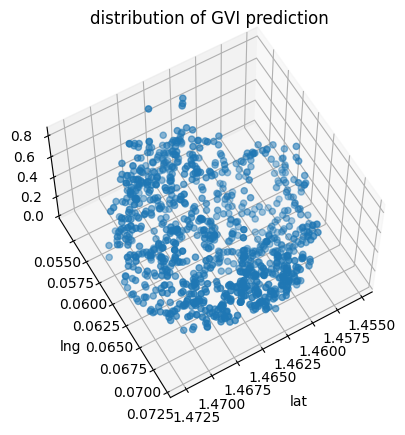

In [31]:
visualize_distribution(DLV3_df_grouped, 60, 60)

In [6]:
def get_clustered_df(df, clustering_instance):
    clustered = pd.concat([df, pd.DataFrame(clustering_instance.labels_)], axis=1)
    clustered.rename(columns= {0: 'cluster'}, inplace=True)

    return clustered

In [7]:
def cluster_ascending_GVI(df):
    '''
    return cluster label in ascending order of GVI
    '''
    ascending_index = df.groupby('cluster')['pred'].mean().sort_values().index.to_list()
    df['cluster_'] = 0
    for i, index_ in enumerate(ascending_index):
        df.loc[df.cluster == index_, 'cluster_'] = i

    df.drop('cluster', axis=1, inplace=True)
    df.rename(columns={'cluster_' : 'cluster'}, inplace=True)

    return df


### Kmeans

Initialization complete
Iteration 0, inertia 9.817581940133113.
Iteration 1, inertia 6.825796173333458.
Iteration 2, inertia 6.20739104552472.
Iteration 3, inertia 5.975640370727723.
Iteration 4, inertia 5.897070468970053.
Initialization complete
Iteration 0, inertia 10.57332512460345.
Iteration 1, inertia 5.8582069798344065.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.189721307852873.
Iteration 1, inertia 6.00072365105555.
Iteration 2, inertia 5.897070468970053.
Iteration 3, inertia 5.878170870477711.
Iteration 4, inertia 5.866767112365437.
Initialization complete
Iteration 0, inertia 7.020508460153746.
Iteration 1, inertia 5.86431074986163.
Converged at iteration 1: center shift 4.358579168482942e-07 within tolerance 5.900880259185954e-07.
Initialization complete
Iteration 0, inertia 10.732056694914526.
Iteration 1, inertia 6.790417560019911.
Iteration 2, inertia 6.118719665408596.
Iteration 3, inertia 5.938981140691508.
Iteration 4, i

Text(0.5, 1.0, 'Determine the number of cluster based on inertia (PixSeg)')

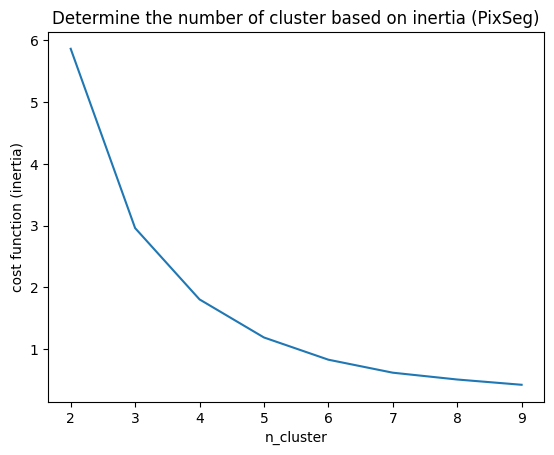

In [48]:
import matplotlib.pyplot as plt

# clustering with kmeans
from sklearn.cluster import KMeans

#Choosing optimal K
cost = []
db_score = []
for num_clusters in list(range(2,10)):
    kmeans = KMeans(n_clusters=num_clusters, verbose=1, max_iter=5)
    kmeans.fit(PixSeg_df_grouped)
    cost.append(kmeans.inertia_)

# plot cost function over different number of clusters
plt.plot(list(range(2,10)), cost)
plt.xlabel('n_cluster')
plt.ylabel('cost function (inertia)')
plt.title('Determine the number of cluster based on inertia (PixSeg)')

Initialization complete
Iteration 0, inertia 17.136661095675052.
Iteration 1, inertia 9.062144456421082.
Iteration 2, inertia 8.202357089932145.
Iteration 3, inertia 7.9773699210272575.
Iteration 4, inertia 7.89644272279758.
Iteration 5, inertia 7.866079589324947.
Iteration 6, inertia 7.8495678222946825.
Iteration 7, inertia 7.845796601561576.
Converged at iteration 7: center shift 1.4931546297260735e-07 within tolerance 8.250885892766621e-07.
Initialization complete
Iteration 0, inertia 11.089985509578923.
Iteration 1, inertia 7.935972337779864.
Iteration 2, inertia 7.884145700602852.
Iteration 3, inertia 7.858062036809855.
Iteration 4, inertia 7.848640481414334.
Iteration 5, inertia 7.845796601561576.
Converged at iteration 5: center shift 1.4931546297260735e-07 within tolerance 8.250885892766621e-07.
Initialization complete
Iteration 0, inertia 20.173041128023527.
Iteration 1, inertia 13.644336030585215.
Iteration 2, inertia 10.310529801649658.
Iteration 3, inertia 8.710024592675753

Text(0.5, 1.0, 'Determine the number of cluster based on inertia (DeepLabV3+)')

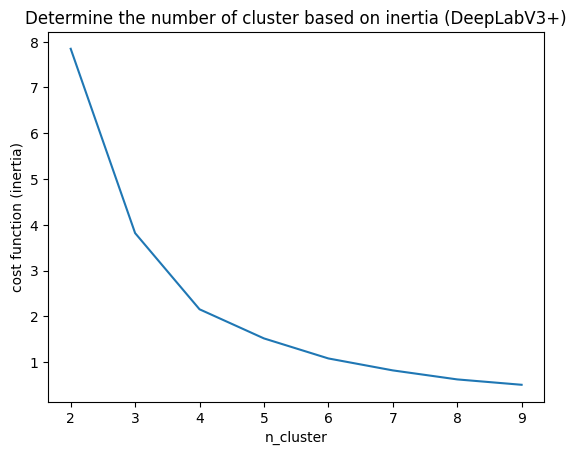

In [49]:
import matplotlib.pyplot as plt

# clustering with kmeans
from sklearn.cluster import KMeans

#Choosing optimal K
cost = []
db_score = []
for num_clusters in list(range(2,10)):
    kmeans = KMeans(n_clusters=num_clusters, verbose=1, max_iter=10)
    kmeans.fit(DLV3_df_grouped)
    cost.append(kmeans.inertia_)

# plot cost function over different number of clusters
plt.plot(list(range(2,10)), cost)
plt.xlabel('n_cluster')
plt.ylabel('cost function (inertia)')
plt.title('Determine the number of cluster based on inertia (DeepLabV3+)')

Initialization complete
Iteration 0, inertia 15.830082898583271.
Iteration 1, inertia 9.045494218753575.
Iteration 2, inertia 9.03935049755573.
Iteration 3, inertia 9.038010527657427.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 15.807281833896775.
Iteration 1, inertia 11.440155691027172.
Iteration 2, inertia 10.02375612735802.
Iteration 3, inertia 9.410344265966916.
Iteration 4, inertia 9.14781141825344.
Iteration 5, inertia 9.059376906330613.
Iteration 6, inertia 9.045957036452663.
Iteration 7, inertia 9.041268647314741.
Converged at iteration 7: center shift 7.045075491398402e-07 within tolerance 9.771745214037886e-07.
Initialization complete
Iteration 0, inertia 13.721629461600966.
Iteration 1, inertia 10.670381073139442.
Iteration 2, inertia 9.642080658431798.
Iteration 3, inertia 9.229479058200432.
Iteration 4, inertia 9.086595993765368.
Iteration 5, inertia 9.050474508273101.
Iteration 6, inertia 9.043920302835554.
Iteration 7, inert

Text(0.5, 1.0, 'Determine the number of cluster based on inertia (DCNN)')

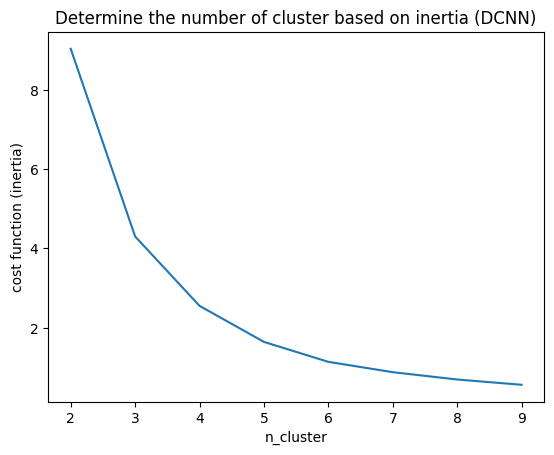

In [47]:
import matplotlib.pyplot as plt

# clustering with kmeans
from sklearn.cluster import KMeans

#Choosing optimal K
cost = []
db_score = []
for num_clusters in list(range(2,10)):
    kmeans = KMeans(n_clusters=num_clusters, verbose=1, max_iter=10)
    kmeans.fit(DCNN_df_grouped)
    cost.append(kmeans.inertia_)

# plot cost function over different number of clusters
plt.plot(list(range(2,10)), cost)
plt.xlabel('n_cluster')
plt.ylabel('cost function (inertia)')
plt.title('Determine the number of cluster based on inertia (DCNN)')

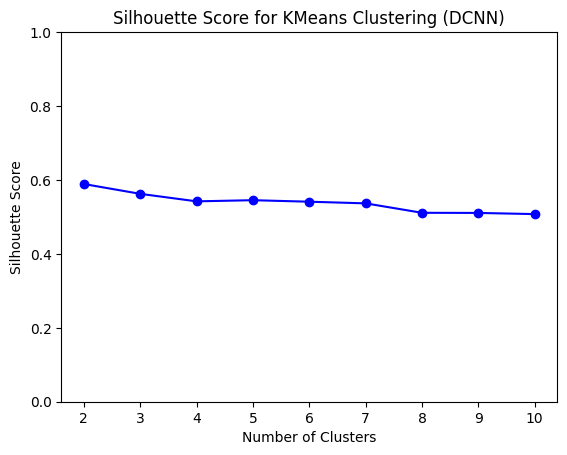

In [45]:
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Define the range of cluster numbers to try
k_values = range(2, 11)  # Adjust the range as needed

# Compute the silhouette score for each cluster number
silhouette_scores = []
for k in k_values:
    model = KMeans(n_clusters=k)
    labels = model.fit_predict(DCNN_df_grouped)  # X is your input data
    score = silhouette_score(DCNN_df_grouped, labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.plot(k_values, silhouette_scores, 'bo-')
plt.ylim(0,1)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for KMeans Clustering (DCNN)')
plt.show()

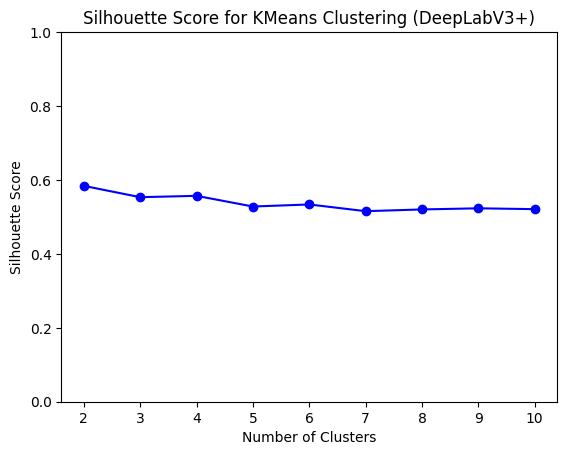

In [44]:
# Define the range of cluster numbers to try
k_values = range(2, 11)  # Adjust the range as needed

# Compute the silhouette score for each cluster number
silhouette_scores = []
for k in k_values:
    model = KMeans(n_clusters=k)
    labels = model.fit_predict(DLV3_df_grouped)  # X is your input data
    score = silhouette_score(DLV3_df_grouped, labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.plot(k_values, silhouette_scores, 'bo-')
plt.ylim(0,1)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for KMeans Clustering (DeepLabV3+)')
plt.show()

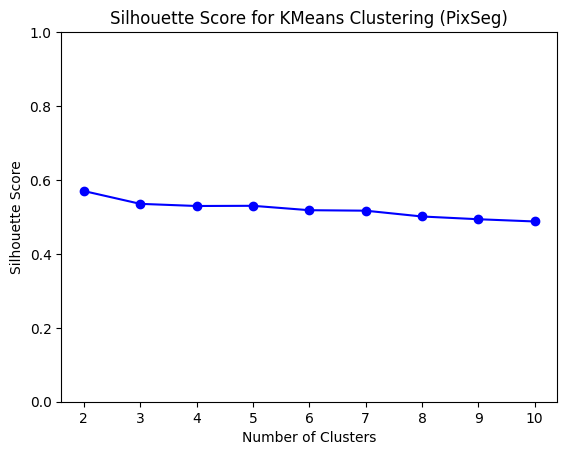

In [43]:
# Define the range of cluster numbers to try
k_values = range(2, 11)  # Adjust the range as needed

# Compute the silhouette score for each cluster number
silhouette_scores = []
for k in k_values:
    model = KMeans(n_clusters=k)
    labels = model.fit_predict(PixSeg_df_grouped)  # X is your input data
    score = silhouette_score(PixSeg_df_grouped, labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.plot(k_values, silhouette_scores, 'bo-')
plt.ylim(0,1)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for KMeans Clustering (PixSeg)')
plt.show()

# agglomerative clustering

### agglomerativeclustering

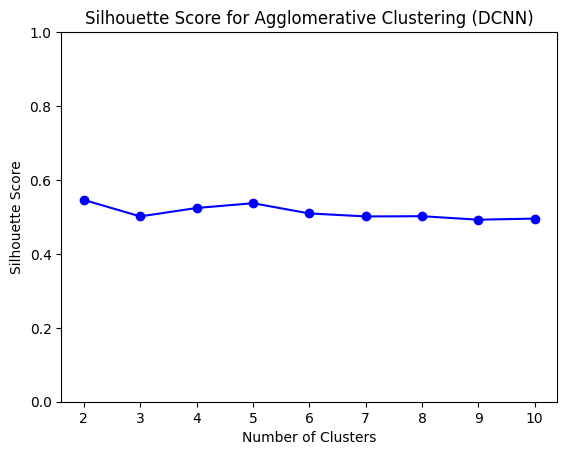

In [42]:
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Define the range of cluster numbers to try
k_values = range(2, 11)  # Adjust the range as needed

# Compute the silhouette score for each cluster number
silhouette_scores = []
for k in k_values:
    model = AgglomerativeClustering(n_clusters=k)
    labels = model.fit_predict(DCNN_df_grouped)  # X is your input data
    score = silhouette_score(DCNN_df_grouped, labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.plot(k_values, silhouette_scores, 'bo-')
plt.ylim(0,1)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Agglomerative Clustering (DCNN)')
plt.show()

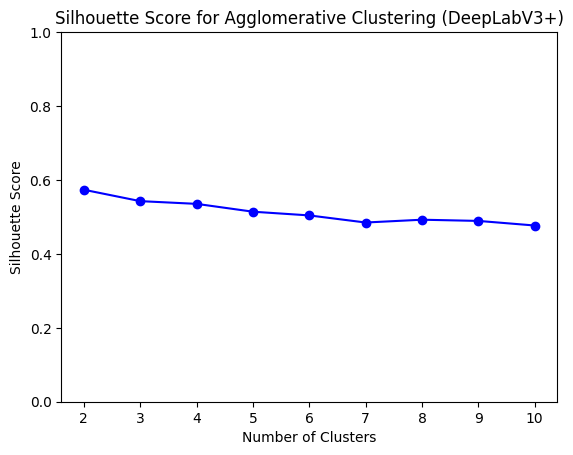

In [41]:
# Define the range of cluster numbers to try
k_values = range(2, 11)  # Adjust the range as needed

# Compute the silhouette score for each cluster number
silhouette_scores = []
for k in k_values:
    model = AgglomerativeClustering(n_clusters=k)
    labels = model.fit_predict(DLV3_df_grouped)  # X is your input data
    score = silhouette_score(DLV3_df_grouped, labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.plot(k_values, silhouette_scores, 'bo-')
plt.ylim(0,1)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Agglomerative Clustering (DeepLabV3+)')
plt.show()

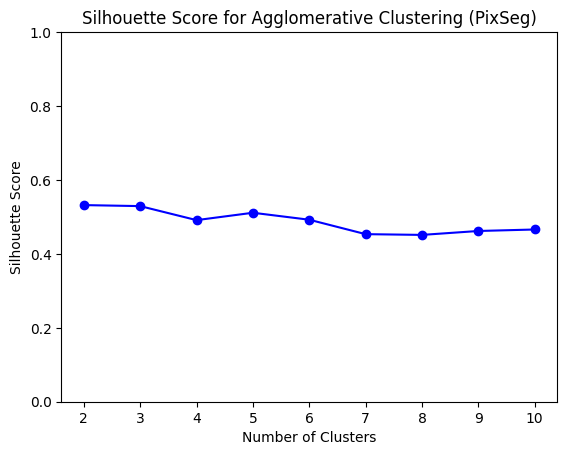

In [46]:
# Define the range of cluster numbers to try
k_values = range(2, 11)  # Adjust the range as needed

# Compute the silhouette score for each cluster number
silhouette_scores = []
for k in k_values:
    model = AgglomerativeClustering(n_clusters=k)
    labels = model.fit_predict(PixSeg_df_grouped)  # X is your input data
    score = silhouette_score(PixSeg_df_grouped, labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.plot(k_values, silhouette_scores, 'bo-')
plt.ylim(0,1)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Agglomerative Clustering (PixSeg)')
plt.show()

## DBSCAN

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances

# Compute the pairwise distance matrix
distance_matrix = pairwise_distances(DCNN_df_grouped)  # X is your input feature matrix

# Define the range of parameter values to try
eps_values = np.linspace(0.1, 1.0, num=10)
min_samples_values = range(2, 10)

best_score = -1
best_params = None

for eps in eps_values:
    for min_samples in min_samples_values:
        model = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
        labels = model.fit_predict(distance_matrix)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters > 1:
            score = silhouette_score(distance_matrix, labels)
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}

if best_params is not None:
    best_model = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'], metric='precomputed')
    labels = best_model.fit_predict(distance_matrix)

    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('DBSCAN Clustering')
    plt.show()
else:
    print("No valid clusters found.")



No valid clusters found.


# visualise clustered data

The method selected to conduct cluster analysis is `AgglomerativeClustering` with `n_clusters` of 4. 

In [50]:
from sklearn.cluster import KMeans
km_clustering_DCNN = KMeans(n_clusters=4)
km_clustering_DLV3 = KMeans(n_clusters=4)
km_clustering_PixSeg = KMeans(n_clusters=4)

km_clustering_DCNN.fit(DCNN_df_grouped)
km_clustering_DLV3.fit(DLV3_df_grouped)
km_clustering_PixSeg.fit(PixSeg_df_grouped)

DCNN_km4 = get_clustered_df(DCNN_df_grouped, km_clustering_DCNN)
DLV3_km4 = get_clustered_df(DLV3_df_grouped, km_clustering_DLV3)
PixSeg_km4 = get_clustered_df(PixSeg_df_grouped, km_clustering_PixSeg)

DCNN_km4 = cluster_ascending_GVI(DCNN_km4)
DLV3_km4 = cluster_ascending_GVI(DLV3_km4)
PixSeg_km4 = cluster_ascending_GVI(PixSeg_km4)

In [9]:
from sklearn.cluster import AgglomerativeClustering
agg_clustering_DCNN = AgglomerativeClustering(n_clusters=5)
agg_clustering_DLV3 = AgglomerativeClustering(n_clusters=5)
agg_clustering_PixSeg = AgglomerativeClustering(n_clusters=5)

agg_clustering_DCNN.fit(DCNN_df_grouped)
agg_clustering_DLV3.fit(DLV3_df_grouped)
agg_clustering_PixSeg.fit(PixSeg_df_grouped)

DCNN_agg5 = get_clustered_df(DCNN_df_grouped, agg_clustering_DCNN)
DLV3_agg5 = get_clustered_df(DLV3_df_grouped, agg_clustering_DLV3)
PixSeg_agg5 = get_clustered_df(PixSeg_df_grouped, agg_clustering_PixSeg)

DCNN_agg5 = cluster_ascending_GVI(DCNN_agg5)
DLV3_agg5 = cluster_ascending_GVI(DLV3_agg5)
PixSeg_agg5 = cluster_ascending_GVI(PixSeg_agg5)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
agg_clustering_DCNN = AgglomerativeClustering(n_clusters=5)
agg_clustering_DLV3 = AgglomerativeClustering(n_clusters=5)
agg_clustering_PixSeg = AgglomerativeClustering(n_clusters=5)

agg_clustering_DCNN.fit(DCNN_df_grouped)
agg_clustering_DLV3.fit(DLV3_df_grouped)
agg_clustering_PixSeg.fit(PixSeg_df_grouped)

DCNN_agg5 = get_clustered_df(DCNN_df_grouped, agg_clustering_DCNN)
DLV3_agg5 = get_clustered_df(DLV3_df_grouped, agg_clustering_DLV3)
PixSeg_agg5 = get_clustered_df(PixSeg_df_grouped, agg_clustering_PixSeg)

DCNN_agg5 = cluster_ascending_GVI(DCNN_agg5)
DLV3_agg5 = cluster_ascending_GVI(DLV3_agg5)
PixSeg_agg5 = cluster_ascending_GVI(PixSeg_agg5)

In [10]:
print(DCNN_agg5.groupby('cluster')['pred'].min())
print(DLV3_agg5.groupby('cluster')['pred'].min())   # 7 clusters not interpretable
print(PixSeg_agg5.groupby('cluster')['pred'].min())  # 

cluster
0    0.012675
1    0.138954
2    0.286890
3    0.414165
4    0.599496
Name: pred, dtype: float64
cluster
0    0.030186
1    0.146299
2    0.269006
3    0.353228
4    0.463284
Name: pred, dtype: float64
cluster
0    0.000000
1    0.165278
2    0.253973
3    0.356528
4    0.503381
Name: pred, dtype: float64


In [53]:
print(DCNN_km4.groupby('cluster')['pred'].min())

cluster
0    0.012675
1    0.171307
2    0.327357
3    0.501539
Name: pred, dtype: float64


In [16]:
print(DCNN_agg3.groupby('cluster')['pred'].min())
print(DLV3_agg7.groupby('cluster')['pred'].min())   # 7 clusters not interpretable
print(PixSeg_agg4.groupby('cluster')['pred'].min())  # 

cluster
0    0.012675
1    0.138954
2    0.414165
Name: pred, dtype: float64
cluster
0    0.030186
1    0.146299
2    0.217532
3    0.269006
4    0.353228
5    0.463284
6    0.540677
Name: pred, dtype: float64
cluster
0    0.000000
1    0.165278
2    0.253973
3    0.356528
Name: pred, dtype: float64


In [12]:
def visualise_clustered(df, plot_height=600, plot_width=600):
    fig = px.scatter_mapbox(df, 
                            lat="lat", 
                            lon="lng", 
                            color='cluster',
                            color_continuous_scale='Viridis',
                            mapbox_style="carto-positron",
                            zoom=8, 
                            height=plot_height,
                            width=plot_width)

    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.show()

In [51]:
visualise_clustered(DCNN_km4, 500, 500)

In [14]:
visualise_clustered(DLV3_agg5, 500, 500)

In [15]:
visualise_clustered(PixSeg_agg5, 500, 500)

In [52]:
DCNN_km4.to_csv("data/output_data/DCNN_km4.csv", index=False)
DLV3_km4.to_csv("data/output_data/DLV3_km4.csv", index=False)
PixSeg_km4.to_csv("data/output_data/PixSeg_km4.csv", index=False)